In [ ]:
import torch
import torch.nn.functional as F
from transformers import AutoProcessor, CLIPModel
from PIL import Image
import numpy as np
import os
from tqdm import tqdm
import pandas as pd
import base64
from io import BytesIO
from sklearn.linear_model import LogisticRegression
from scipy.ndimage import binary_dilation
import hashlib

In [2]:
root_path = "/home/stefan/ioai-prep/kits/neoai-2025/cuties-segmentation"
val_imgs_path = f'{root_path}/cuties/val_imgs'
val_masks_path = f'{root_path}/cuties/val_masks'

device = 'cuda'

In [3]:
model_name = "openai/clip-vit-base-patch16"
processor = AutoProcessor.from_pretrained(model_name)
model = CLIPModel.from_pretrained(model_name).to(device)
model.eval()

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e-05,

In [ ]:
class_names = [
    'american_bulldog', 'basset_hound', 'keeshond', 'British_Shorthair', 'Sphynx',
    'pomeranian', 'Egyptian_Mau', 'Birman', 'american_pit_bull_terrier', 'japanese_chin',
    'Maine_Coon', 'beagle', 'Bombay', 'wheaten_terrier', 'shiba_inu', 'havanese',
    'miniature_pinscher', 'yorkshire_terrier', 'boxer', 'scottish_terrier', 'newfoundland',
    'chihuahua', 'saint_bernard', 'Persian', 'Bengal', 'german_shorthaired',
    'english_cocker_spaniel', 'leonberger', 'Siamese', 'Abyssinian',
    'staffordshire_bull_terrier', 'Ragdoll', 'pug', 'Russian_Blue', 'samoyed',
    'english_setter', 'great_pyrenees'
]

def get_text_embeddings():
    classes = [f"a photo of a {' '.join(x.lower().split('_'))}" for x in class_names]
    additional_prompts = ["a photo of a cat or dog", "a photo of background"]
    all_prompts = classes + additional_prompts
    with torch.no_grad():
        tokenized = processor(text=all_prompts, images=None, return_tensors="pt", padding=True).to(device)
        text_embeds = model.get_text_features(**tokenized)
        text_embeds = F.normalize(text_embeds, dim=-1)
    return text_embeds, len(classes)


def get_clip_activations(image):
    with torch.no_grad():
        inputs = processor(text=None, images=image, return_tensors="pt", padding=True).to(device)
        outputs = model.vision_model(**inputs, output_hidden_states=True)
        list_activations = []
        for ix in [3, 7, 9, -1]:
            activations = outputs.hidden_states[ix][:, 1:, :]  # [batch, 196, 768]
            activations = F.normalize(activations, dim=-1)
            list_activations.append(activations)
    activations = torch.cat(list_activations, -1)
    return activations

def binaryMaskIOU(mask1, mask2):
    assert mask1.shape == mask2.shape
    mask1_area = np.count_nonzero(mask1 == 1)
    mask2_area = np.count_nonzero(mask2 == 1)
    intersection = np.count_nonzero(np.logical_and(mask1 == 1, mask2 == 1))
    union = mask1_area + mask2_area - intersection
    return intersection / union if union > 0 else 0.0

# train classifer in val data
def train_classifier(val_imgs_path, val_masks_path, text_embeds, num_classes):
    X_train = []
    y_train = []
    
    for img_name in tqdm(os.listdir(val_imgs_path), desc="Collecting training data"):
        img = Image.open(os.path.join(val_imgs_path, img_name)).resize((224, 224))
        gt_mask = Image.open(os.path.join(val_masks_path, img_name.replace('.jpg', '.png')))
        gt_mask = np.array(gt_mask.resize((14, 14), Image.NEAREST)) // 255
        
        activations = get_clip_activations(img)  # [1, 196, 768]
        activations = activations.reshape(14, 14, -1).cpu().numpy()  # [14, 14, 768]
        
        for i in range(14):
            for j in range(14):
                X_train.append(activations[i, j])
                y_train.append(gt_mask[i, j])
    
    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_train, y_train)
    return clf

def generate_mask(img, text_embeds, num_classes, clf, threshold=0.5):
    img_shapes = np.array(img).shape[:2]
    img_resized = img.resize((224, 224))
    
    activations = get_clip_activations(img_resized)  # [1, 196, 768]
    activations = activations.reshape(14, 14, -1).cpu().numpy()  # [14, 14, 768]
    
    heatmap = np.zeros((14, 14))
    for i in range(14):
        for j in range(14):
            prob = clf.predict_proba([activations[i, j]])[0, 1]
            heatmap[i, j] = prob
    
    heatmap = torch.tensor(heatmap).unsqueeze(0).unsqueeze(0)
    heatmap = F.interpolate(heatmap, size=(224, 224), mode='bilinear', align_corners=False)
    heatmap = heatmap.squeeze().numpy()
    mask = (heatmap > threshold).astype(np.uint8)
    mask = binary_dilation(mask, iterations=1)
    
    mask = np.array(Image.fromarray(mask).resize(img_shapes[::-1], Image.NEAREST))
    return mask.astype(np.uint8), heatmap

def generate_seg_masks(imgs_path, val_masks_path=None, is_validation=False):
    text_embeds, num_classes = get_text_embeddings()
    img_names = []
    seg_masks = []
    
    clf = train_classifier(imgs_path if is_validation else val_imgs_path, val_masks_path, text_embeds, num_classes)
    
    thresholds = np.arange(0.3, 0.8, 0.05)
    best_threshold = 0.5
    best_iou = 0.0
    if is_validation:
        temp_masks = []
        temp_names = []
        
        for img_name in tqdm(os.listdir(imgs_path), desc="Processing validation"):
            img = Image.open(os.path.join(imgs_path, img_name))
            mask, _ = generate_mask(img, text_embeds, num_classes, clf)
            temp_names.append(img_name)
            temp_masks.append(mask)
        
        for threshold in thresholds:
            ious = []
            for img_name, mask in zip(temp_names, temp_masks):
                gt_mask = Image.open(os.path.join(val_masks_path, img_name.replace('.jpg', '.png')))
                gt_mask = np.array(gt_mask) // 255
                pred_mask = (mask > threshold).astype(np.uint8)
                iou = binaryMaskIOU(pred_mask, gt_mask)
                ious.append(iou)
            
            mean_iou = np.mean(ious)
            if mean_iou > best_iou:
                best_iou = mean_iou
                best_threshold = threshold
        
        print(f"Best threshold: {best_threshold}, Validation IoU: {best_iou}")
    
    for img_name in tqdm(os.listdir(imgs_path), desc="Processing images"):
        img = Image.open(os.path.join(imgs_path, img_name))
        mask, _ = generate_mask(img, text_embeds, num_classes, clf, best_threshold)
        img_names.append(img_name)
        seg_masks.append(mask)
    
    return img_names, seg_masks

def create_submission(img_names, seg_masks):
    ids = []
    b64 = []
    for img_name, seg_mask in zip(img_names, seg_masks):
        ids.append(img_name[:-4])
        seg_mask = (seg_mask * 255).astype(np.uint8)
        print(f"Processing {img_name}, mask shape: {seg_mask.shape}, dtype: {seg_mask.dtype}")
        mask = Image.fromarray(seg_mask, mode="L")
        buf = BytesIO()
        mask.save(buf, format="PNG")
        b64.append(base64.b64encode(buf.getvalue()).decode("utf-8"))
    
    df = pd.DataFrame({"img_id": [int(id_) for id_ in ids], "mask": b64})
    hsh = hashlib.sha256(df.to_csv(index=False).encode('utf-8')).hexdigest()[:8]
    submit_path = f"submission_{hsh}.csv"
    df.to_csv(submit_path, index=False)
    print(f"SUBMIT_NAME: {submit_path}")
    return df

In [6]:
val_img_names, val_seg_masks = generate_seg_masks(val_imgs_path, val_masks_path, is_validation=True)

val_ious = []
for img_name, seg_mask in zip(val_img_names, val_seg_masks):
    gt_mask = Image.open(os.path.join(val_masks_path, img_name.replace('.jpg', '.png')))
    gt_mask = np.array(gt_mask) // 255
    iou = binaryMaskIOU(seg_mask, gt_mask)
    val_ious.append(iou)
print(f"Mean Validation IoU: {np.mean(val_ious)}")

test_imgs_path = f'{root_path}/cuties/test_imgs'
test_img_names, test_seg_masks = generate_seg_masks(test_imgs_path, val_masks_path)
df = create_submission(test_img_names, test_seg_masks)

Processing validation: 100%|██████████| 20/20 [00:00<00:00, 21.99it/s]


Best threshold: 0.3, Validation IoU: 0.8248830109150326


Processing images: 100%|██████████| 20/20 [00:00<00:00, 23.00it/s]


Mean Validation IoU: 0.7673205349673675


Processing images: 100%|██████████| 1000/1000 [00:42<00:00, 23.57it/s]


Processing 822.jpg, mask shape: (500, 377), dtype: uint8
Processing 500.jpg, mask shape: (500, 375), dtype: uint8
Processing 434.jpg, mask shape: (375, 500), dtype: uint8
Processing 560.jpg, mask shape: (309, 500), dtype: uint8
Processing 364.jpg, mask shape: (333, 500), dtype: uint8
Processing 258.jpg, mask shape: (375, 500), dtype: uint8
Processing 220.jpg, mask shape: (224, 300), dtype: uint8
Processing 217.jpg, mask shape: (309, 500), dtype: uint8
Processing 77.jpg, mask shape: (432, 500), dtype: uint8
Processing 755.jpg, mask shape: (500, 356), dtype: uint8
Processing 928.jpg, mask shape: (401, 500), dtype: uint8
Processing 243.jpg, mask shape: (225, 300), dtype: uint8
Processing 613.jpg, mask shape: (375, 500), dtype: uint8
Processing 387.jpg, mask shape: (500, 375), dtype: uint8
Processing 677.jpg, mask shape: (332, 500), dtype: uint8
Processing 10.jpg, mask shape: (500, 333), dtype: uint8
Processing 530.jpg, mask shape: (500, 374), dtype: uint8
Processing 331.jpg, mask shape: (

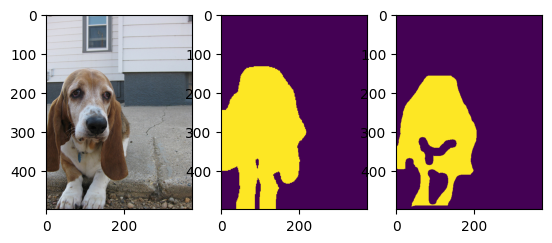

In [8]:
import matplotlib.pyplot as plt

NUM_VIS_IMG = 0
f, axes = plt.subplots(1,3)
axes[0].imshow(np.array(
    Image.open(os.path.join(val_imgs_path, val_img_names[NUM_VIS_IMG]))
    )
)

axes[1].imshow(val_seg_masks[NUM_VIS_IMG])
axes[2].imshow(np.array(
    Image.open(os.path.join(val_masks_path, val_img_names[NUM_VIS_IMG].replace('jpg', 'png')))
    )
)